In [1]:
"""
Hidden Shift Benchmark Program - Qiskit
"""

import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

sys.path[1:1] = [ "_common", "_common/qiskit" ]
sys.path[1:1] = [ "../../_common", "../../_common/qiskit" ]
import execute as ex
import metrics as metrics

# Benchmark Name
benchmark_name = "Hidden Shift"

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
Uf_ = None
Ug_ = None


In [2]:
############### Circuit Definition

# Uf oracle where Uf|x> = f(x)|x>, f(x) = {-1,1}
def Uf_oracle(num_qubits, secret_int):
    # Initialize qubits qubits
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr, name="Uf")

    # Perform X on each qubit that matches a bit in secret string
    s = ('{0:0'+str(num_qubits)+'b}').format(secret_int)
    for i_qubit in range(num_qubits):
        if s[num_qubits-1-i_qubit]=='1':
            qc.x(qr[i_qubit])

    for i_qubit in range(0,num_qubits-1,2):
        qc.cz(qr[i_qubit], qr[i_qubit+1])

    # Perform X on each qubit that matches a bit in secret string
    s = ('{0:0'+str(num_qubits)+'b}').format(secret_int)
    for i_qubit in range(num_qubits):
        if s[num_qubits-1-i_qubit]=='1':
            qc.x(qr[i_qubit])

    return qc

# Generate Ug oracle where Ug|x> = g(x)|x>, g(x) = f(x+s)
def Ug_oracle(num_qubits):
    # Initialize first n qubits
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr, name="Ug")

    for i_qubit in range(0,num_qubits-1,2):
        qc.cz(qr[i_qubit], qr[i_qubit+1])

    return qc


def HiddenShift (num_qubits, secret_int):
    
    # allocate qubits
    qr = QuantumRegister(num_qubits); cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr, cr, name=f"hs-{num_qubits}-{secret_int}")
    
    # Start with Hadamard on all input qubits
    for i_qubit in range(num_qubits):
         qc.h(qr[i_qubit])

    qc.barrier()

    # Generate Uf oracle where Uf|x> = f(x)|x>, f(x) = {-1,1}
    Uf = Uf_oracle(num_qubits, secret_int)
    qc.append(Uf,qr)

    qc.barrier()
    
    # Again do Hadamard on all qubits
    for i_qubit in range(num_qubits):
         qc.h(qr[i_qubit])

    qc.barrier()

    # Generate Ug oracle where Ug|x> = g(x)|x>, g(x) = f(x+s)
    Ug = Ug_oracle(num_qubits)
    qc.append(Ug,qr)

    qc.barrier()

    # End with Hadamard on all qubits
    for i_qubit in range(num_qubits):
         qc.h(qr[i_qubit])
        
    qc.barrier()
    
    # measure all qubits
    qc.measure(qr, cr)

    # save smaller circuit example for display
    global QC_, Uf_, Ug_
    if QC_ == None or num_qubits <= 6:
        if num_qubits < 9: QC_ = qc
    if Uf_ == None or num_qubits <= 6:
        if num_qubits < 9: Uf_ = Uf
    if Ug_ == None or num_qubits <= 6:
        if num_qubits < 9: Ug_ = Ug
        
    # return a handle on the circuit
    return qc


In [3]:
############### Circuit end

# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result (qc, result, num_qubits, secret_int, num_shots):
    
    # obtain counts from the result object
    counts = result.get_counts(qc)
    if verbose: print(f"For secret int {secret_int} measured: {counts}")
    
    # create the key that is expected to have all the measurements (for this circuit)
    key = format(secret_int, f"0{num_qubits}b")
    
    # correct distribution is measuring the key 100% of the time
    correct_dist = {key: 1.0}

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)
        
    return counts, fidelity



Hidden Shift Benchmark Program - Qiskit
... execution starting at Sep 03, 2024 10:30:54 UTC
************
Executing [3] circuits with num_qubits = 2
************
Executing [3] circuits with num_qubits = 4
************
Average Circuit Algorithmic Depth, ξ (xi) for the 2 qubit group = 8, 0.189
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 2 qubit group = 16, 0.091, 2.0
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.001, 0.167, 0.01 secs
Average Transpiling, Validating, Running Times for group 2 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 6
************
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 8, 0.215
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 17, 0.089, 4.0
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.001, 0.485, 0.002 secs
Average Transpiling, Validating, Runni

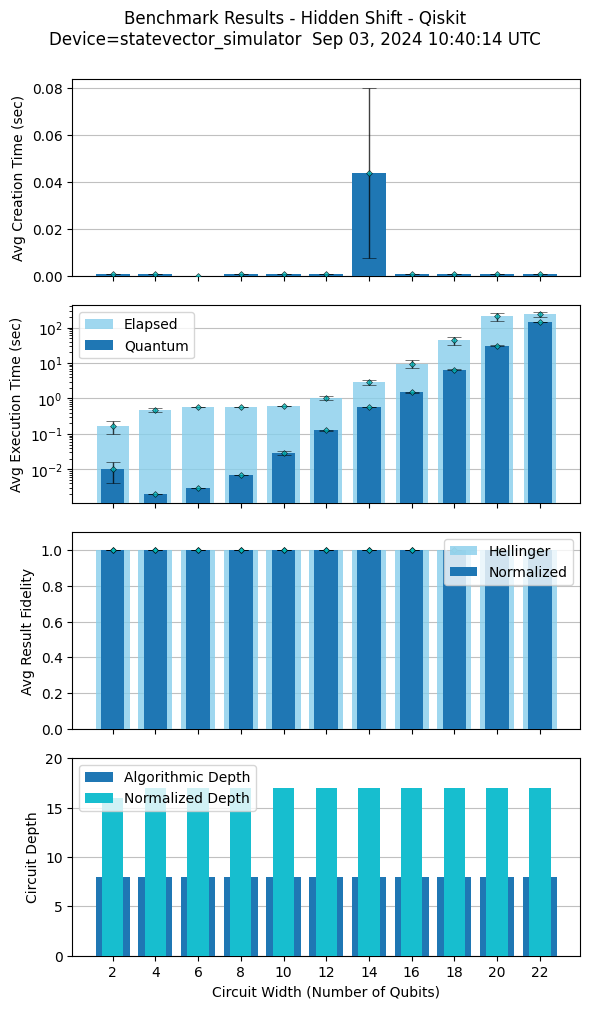

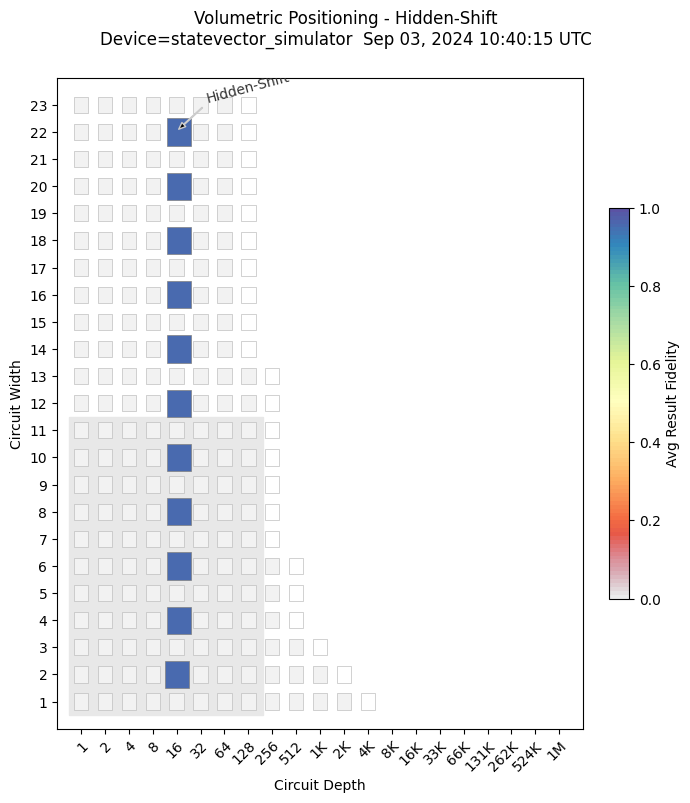

In [4]:
################ Benchmark Loop

# Execute program with default parameters
def run (min_qubits=2, max_qubits=22, skip_qubits=2, max_circuits=3, num_shots=1000,
        backend_id='statevector_simulator', provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} Benchmark Program - Qiskit")

    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    if min_qubits % 2 == 1: min_qubits += 1                  # min_qubits must be even
    skip_qubits = max(2, skip_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # create context identifier
    if context is None: context = f"{benchmark_name} Benchmark"
    
    ##########
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, num_qubits, s_int, num_shots):  
     
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, 2):

        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_qubits), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(num_qubits) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            # create selection larger than needed and remove duplicates (faster than random.choice())
            s_range = np.random.randint(1, 2**(num_qubits), num_circuits + 10)
            s_range = list(set(s_range))[0:max_circuits]
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
        
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = HiddenShift(num_qubits, s_int)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time()-ts)

            # collapse the sub-circuit levels used in this benchmark (for qiskit)
            qc2 = qc.decompose()

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, num_qubits, s_int, shots=num_shots)
        
        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)
    
    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)

    ##########
    
    # # print a sample circuit
    # print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    # print("\nQuantum Oracle 'Uf' ="); print(Uf_ if Uf_ != None else " ... too large!")
    # print("\nQuantum Oracle 'Ug' ="); print(Ug_ if Ug_ != None else " ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} - Qiskit")

# if main, execute method
if __name__ == '__main__': run()
